# Simulate Test

Notebook to simulate testing technical knowledge of users.


## Setup


In [8]:
import json
import random
import glob
import uuid
from openai import OpenAI
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import cm
from matplotlib.ticker import FixedLocator
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from config import TOPICS, TOPIC_GROUPS, SKILL_LEVELS

random.seed()

## Configurations


In [9]:
TOPICS2 = [
    "Artificial Intelligence",
    "Automated Testing",
    "AWS",
    "Cloud Platforms",
    "Cloud Security",
    "Computer Science",
    "Continuous Delivery",
    "Continuous Deployment",
    "Continuous Integration",
    "Cybersecurity",
    "Data Analysis",
    "Data Engineering",
    "Data Science",
    "DevOps",
    "Enterprise Architecture",
    "Git",
    "Infrastructure as Code",
    "JavaScript",
    "Machine Learning",
    "Microservices",
    "Network Security",
    "Penetration Testing",
    "Platform Engineering",
    "Python",
    "React",
    "Site Reliability Engineering",
    "Software Architecture",
    "Software Engineering",
    "Solutions Architecture",
    "Web Development",
]


TOPIC_GROUPS2 = {
    "Software Development": [
        "Computer Science",
        "Software Engineering",
        "JavaScript",
        "Python",
        "React",
        "Git",
    ],
    "Software Architecture": [
        "Software Architecture",
        "Microservices",
        "Enterprise Architecture",
    ],
    "DevOps": [
        "DevOps",
        "Continuous Integration",
        "Continuous Delivery",
        "Continuous Deployment",
        "Site Reliability Engineering",
        "Platform Engineering",
        "Infrastructure as Code",
    ],
    "Security": [
        "Penetration Testing",
        "Network Security",
        "Cloud Security",
        "Cybersecurity",
    ],
    "Data Science & Engineering": [
        "Data Science",
        "Data Engineering",
        "Machine Learning",
        "Artificial Intelligence",
        "Data Analysis",
    ],
    "Cloud & Infrastructure": ["AWS", "Cloud Platforms"],
    "Quality Assurance & Testing": ["Automated Testing"],
}


SKILL_LEVELS2 = ["beginner", "intermediate", "advanced", "expert", "master"]

## Utilities


In [10]:
def read_files(glob_pattern):
    files_contents = {}
    for file_path in glob.glob(glob_pattern):
        try:
            with open(file_path, "r") as file:
                files_contents[file_path] = file.read()
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    return files_contents


def group_by(collection, key):
    grouped = {}
    for item in collection:
        group_key = item[key]

        if group_key not in grouped:
            grouped[group_key] = []

        grouped[group_key].append(item)
    return grouped


def key_by(collection, key):
    grouped = {}
    for item in collection:
        group_key = item[key] if type(item) is dict else getattr(item, key, None)
        grouped[group_key] = item
    return grouped


def to_key(text):
    return "_".join(word.lower() for word in text.split())


def plot_user_results(dataframe, users, topics=None):
    if isinstance(users, str):
        users = [users]

    for user in users:
        # Filter DataFrame for the specified user
        user_df = dataframe[dataframe["user"] == user]

        # Optionally filter by specified topics
        if topics is not None:
            user_df = user_df[user_df["topic"].isin(topics)]

        # Filter rows where score is 70 or higher
        user_df = user_df[user_df["score"] >= 70]

        # Group by 'topic' and find the index of the max 'difficulty_level' for each topic
        idx = user_df.groupby("topic")["difficulty_level"].idxmax()

        # Use the index to filter the original DataFrame
        user_df = user_df.loc[idx]

        # Group by topic and difficulty level, calculate the average score
        performance_by_difficulty = (
            user_df.groupby(["topic", "difficulty_level"])["score"]
            .mean()
            .unstack(fill_value=0)
        )
        # print(performance_by_difficulty)

        # If no data is left after filtering, continue to the next user
        if performance_by_difficulty.empty:
            print(f"No data available for {user} with the specified topics.")
            continue

        # Prepare data for circular bar chart
        performance_flat = performance_by_difficulty.reset_index().melt(
            id_vars="topic", var_name="difficulty_level", value_name="performance"
        )
        # performance_flat["category"] = (
        #     performance_flat["topic"]
        #     + " ("
        #     + performance_flat["difficulty_level"].astype(str)
        #     + ")"
        # )
        performance_flat["category"] = performance_flat["topic"]

        # Number of bars to plot
        N = len(performance_flat)
        theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

        # The performance metric determines the length of the bars
        radii = (
            performance_flat["performance"] * 10
        )  # Scale factor for better visualization

        # Plotting the circular bar chart
        fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
        bars = ax.bar(
            theta, radii, width=0.3, bottom=0.2, color=cm.viridis(radii / 10.0)
        )

        # Setting the y-tick labels
        ax.yaxis.set_major_locator(
            FixedLocator([0, 2, 4, 6, 8, 10])
        )  # Assuming the scale factor for radii is up to 10
        ax.set_yticklabels(
            ["", "Beginner", "Intermediate", "Advanced", "Expert", "Master"]
        )

        ax.set_xticks(theta)
        ax.set_xticklabels(
            performance_flat["category"], rotation=45, ha="right", fontsize=10
        )

        plt.title(
            f"{user}",
            fontsize=16,
        )
        plt.show()


def simulate_skill_levels(topics, skill_levels):
    result = {}
    for topic in topics:
        result[topic] = random.choice(skill_levels)
    return result


def simulate_response(skill_level):
    if skill_level == "master":
        return True
    elif skill_level == "expert":
        return random.choice([True, True, True, True, False])
    elif skill_level == "advanced":
        return random.choice([True, True, True, False, False])
    elif skill_level == "intermediate":
        return random.choice([True, True, False, False, False])
    elif skill_level == "beginner":
        return random.choice([True, False, False, False, False])
    else:
        raise ValueError("Unknown skill level")


def simulate_test_session(data, skill_levels):
    knowledge_levels = []
    topics = key_by(data, key="topic")

    for topic_name, topic in topics.items():
        topic_choices_by_question_id = key_by(topic["choices"], key="question_id")
        valid_questions = [
            question
            for question in topic["questions"]
            if question["id"] in topic_choices_by_question_id
        ]
        topic_questions_by_difficulty = group_by(valid_questions, key="difficulty")
        for (
            current_difficulty,
            current_difficulty_questions,
        ) in topic_questions_by_difficulty.items():
            correct_answers = 0
            question_count = len(current_difficulty_questions)
            for current_difficulty_question in current_difficulty_questions:
                # print(current_level_question)
                is_correct = simulate_response(skill_levels[topic_name])
                if is_correct:
                    correct_answers += 1

            knowledge_levels.append(
                {
                    "topic": topic_name,
                    "difficulty_level": current_difficulty,
                    "correct_answers": correct_answers,
                    "total_questions": question_count,
                }
            )

    return knowledge_levels


def load_test_data(file_paths):
    test_data = [json.loads(topic) for topic in read_files(file_paths).values()]
    valid_test_data = []
    for test_datum in test_data:
        if "choices" in test_datum:
            # print(test_datum)
            valid_test_data.append(test_datum)

    return valid_test_data


def darken_color(color, factor=0.5):
    """Darken a given color by a specified factor."""
    # Extract RGB components from the color and multiply each by the factor, keep alpha unchanged
    darkened_color = (color[0] * factor, color[1] * factor, color[2] * factor, color[3])
    return darkened_color


def create_circular_bar_chart(
    df,
    username,
    topics=None,
    skill_levels=SKILL_LEVELS,
    category_colormap="Accent",
    topic_colormap="plasma",
    title_color="black",
    label_color="black",
    border_color="lightgrey",
):
    # Filter for the specified user
    user_df = df[df["user"] == username]

    # Further filter for specified topics if any
    if topics is not None:
        user_df = user_df[user_df["topic"].isin(topics)]

    # Determine the highest level passed for each topic, default to level 1 if none passed
    highest_levels = {}
    topic_categories = {}
    for topic in user_df["topic"].unique():
        topic_df = user_df[user_df["topic"] == topic]
        passed_levels = topic_df[topic_df["passed"] == True]
        highest_passed_level = (
            passed_levels["difficulty_level"].max() if not passed_levels.empty else 1
        )
        category = topic_df["category"].iloc[0]
        highest_levels[topic] = highest_passed_level
        topic_categories[topic] = category

    # Sort topics by category
    sorted_topics = sorted(
        highest_levels.keys(), key=lambda x: (topic_categories[x], x)
    )
    categories = sorted(set(topic_categories.values()))

    # Assign a color to each category
    category_colormap = plt.get_cmap(category_colormap, len(categories))
    category_colors = {
        category: category_colormap(i) for i, category in enumerate(categories)
    }

    num_vars = len(sorted_topics)
    labels = [label.replace(" ", "\n") for label in sorted_topics]
    stats = [highest_levels[topic] for topic in sorted_topics]

    # Compute angle for each bar, considering sorted order
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    width = 2 * np.pi / num_vars - 0.02  # Adjust for gaps between bars

    # Start figure
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
    ax.set_ylim(0, max(stats) + 1)

    # Fill background for each category
    start_angle = 0
    for category in categories:
        # Count how many topics are in the current category
        category_count = sum(
            1 for topic in sorted_topics if topic_categories[topic] == category
        )
        end_angle = start_angle + category_count * (2 * np.pi / num_vars)
        # Fill the entire area for the category
        ax.fill_between(
            np.linspace(start_angle, end_angle, 100),
            0,
            max(stats) + 1,
            color=category_colors[category],
            alpha=0.2,
            zorder=0,
        )
        start_angle = end_angle  # Prepare start angle for next category

    # Draw bars
    for i, (angle, stat) in enumerate(zip(angles, stats)):
        bar_color = plt.get_cmap(topic_colormap)(i / num_vars)
        darkened_edge_color = darken_color(bar_color, factor=0.5)
        plt.bar(
            angle,
            stat,
            width=width,
            color=bar_color,
            edgecolor=darkened_edge_color,
            linewidth=1,
            alpha=0.7,
        )

    # Set the border styles and colors
    ax.tick_params(colors=border_color)
    ax.spines["polar"].set_color(border_color)
    ax.xaxis.grid(color=border_color, linestyle="--")
    ax.yaxis.grid(color=border_color, linestyle="--")

    # Set the skill level labels
    plt.yticks(range(1, 6), skill_levels, color=label_color, size=7)
    plt.ylim(0, 5)

    # Set the topic labels for each bar
    ax.set_xticks(angles)
    ax.set_xticklabels(
        labels,
        color=label_color,
        size=12,
        weight="semibold",
        rotation=45,
        ha="center",
        va="center",
    )

    # Display the title
    plt.title(f"Results for {username}", size=20, color=title_color, y=1.1)

    plt.show()

## Simulation


In [11]:
test_data = load_test_data("./data/*.json")
users = ["janedoe", "johndoe", "suzyq", "mbrown"]

user_results = []
for user in users:
    user_skill_levels = simulate_skill_levels(TOPICS, SKILL_LEVELS)
    user_test_results = simulate_test_session(test_data, user_skill_levels)

    for user_test_result in user_test_results:
        user_results.append({"user": user, **user_test_result})

## Data


In [12]:
topics_df = pd.DataFrame(TOPIC_GROUPS.items(), columns=["category", "topic"]).explode(
    "topic"
)
user_results_df = pd.DataFrame(user_results)
user_results_df["score"] = (
    user_results_df["correct_answers"] / user_results_df["total_questions"] * 100
)
user_results_df["score"] = user_results_df["score"].astype(int)
user_results_df["passed"] = user_results_df["score"] >= 70
user_results_df["skill_level"] = user_results_df["difficulty_level"].apply(
    lambda x: SKILL_LEVELS[x - 1]
)


user_results_df = user_results_df.merge(topics_df, on="topic")

## Results


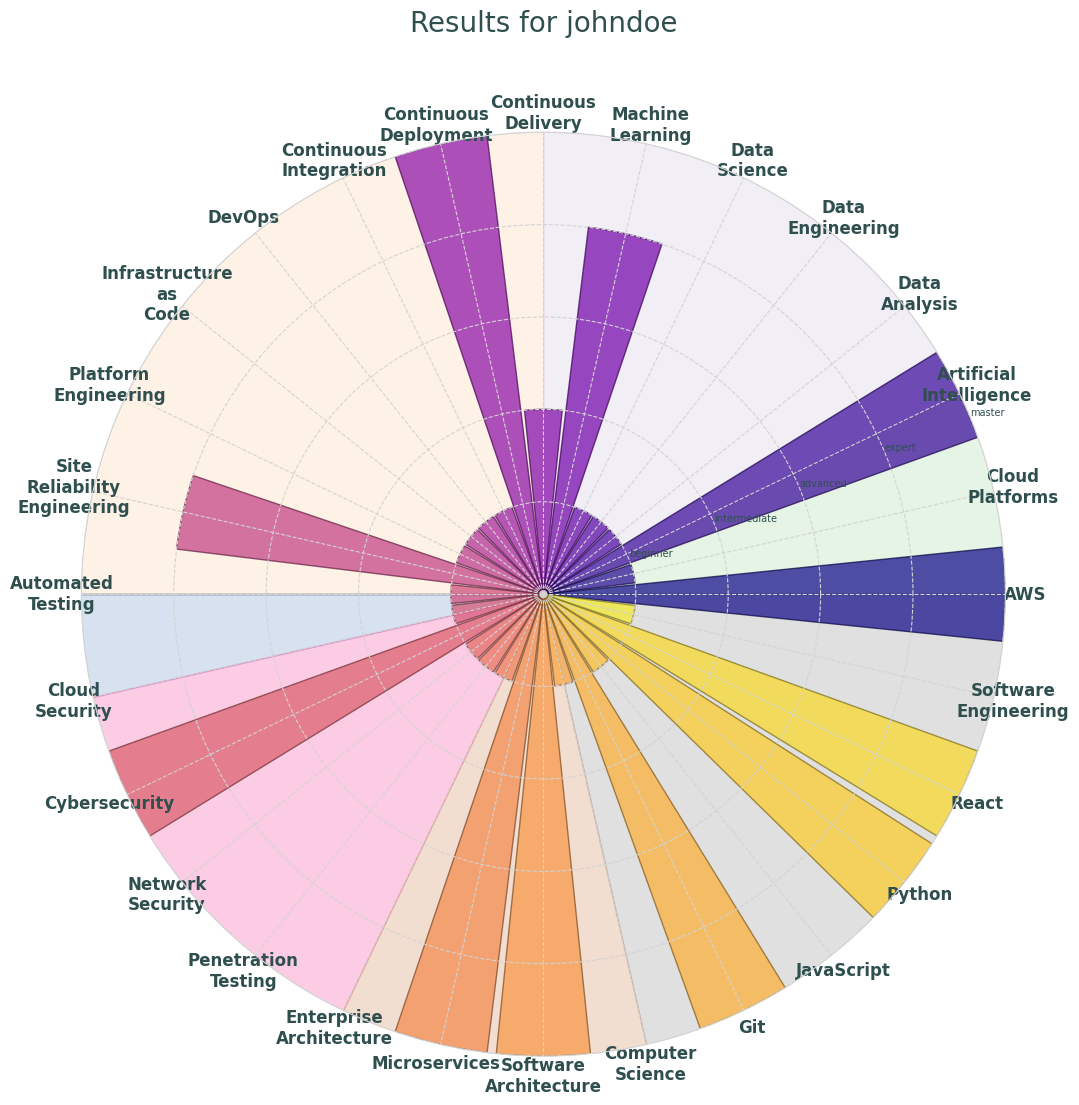

In [13]:
create_circular_bar_chart(
    user_results_df,
    username="johndoe",
    label_color="darkslategrey",
    title_color="darkslategrey",
)